In [ ]:
#mount drive
%cd ..
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Projects/YOLO_V8_and_ByteTrack


/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack/ByteTrack
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack


##Check if we are using GPU

In [ ]:
!nvidia-smi

Sat May 20 21:01:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    54W / 400W |  12901MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Creating the video


In [ ]:
import cv2
import os
from PIL import Image
# Set input/output directories
basic_folder= '/content/drive/MyDrive/Projects/YOLO_V8_and_ByteTrack/'
dataset_path= basic_folder+'Video/MOT15/train/Venice-2/'
out_video_name = 'Venice-2_of.mp4'
#to modify for all new video
####



path = dataset_path+'img1'
out_path = dataset_path+'Video'

           
out_video_full_path = os.path.join(out_path, out_video_name)

pre_imgs = os.listdir(path)
sorted_imgs = sorted(pre_imgs)  # Sort the image files

img_paths = [os.path.join(path, img) for img in sorted_imgs]

cv2_fourcc = cv2.VideoWriter_fourcc(*'mp4v')

frame = cv2.imread(img_paths[0])

if frame is None:
    raise ValueError(f"Failed to read the image: {img_paths[0]}")

size = list(frame.shape[:2])
size.reverse()

video = cv2.VideoWriter(out_video_full_path, cv2_fourcc, 24, size) #output video name, fourcc, fps, size

for img_path in img_paths: 
    frame = cv2.imread(img_path)

    if frame is None:
        print(f"Failed to read the image: {img_path}")
        continue

    video.write(frame)
    #print('Processed image:', img_path)

video.release()
print('Outputted video to:', out_video_full_path)


Outputted video to: /content/drive/MyDrive/Projects/YOLO_V8_and_ByteTrack/Video/MOT15/train/Venice-2/Video/Venice-2_of.mp4


##Getting the video

In [ ]:
%cd /content/drive/MyDrive/Projects/YOLO_V8_and_ByteTrack/Video

/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack/Video


In [ ]:
SOURCE_VIDEO_PATH = dataset_path+"Video/"+out_video_name 

## Install YOLOv8


In [ ]:
# Pip install method (recommended)

# if you encounter a problem with the ultralytics version used, run the next two lines
#!pip install --upgrade ultralytic
#!pip uninstall ultralytics

!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.105 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.4/78.2 GB disk)


## Install ByteTrack

In [ ]:
#!git clone https://github.com/ifzhang/ByteTrack.git

In [ ]:
folder = basic_folder+"ByteTrack"
%cd $folder
# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
from IPython import display
display.clear_output()

In [ ]:
! pip install thop
import sys
sys.path.append(basic_folder+"ByteTrack")
!pip install loguru
import yolox
print("yolox.__version__:", yolox.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
yolox.__version__: 0.1.0


## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0
from IPython import display
display.clear_output()
import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator



## Modification de matching py et bytetracker

# bytetracker

In [ ]:
folder= basic_folder+'ByteTrack/yolox/tracker'
%cd $folder

import numpy as np
from collections import deque
import os
import os.path as osp
import copy
import torch
import torch.nn.functional as F

from kalman_filter import KalmanFilter
#from yolox.tracker import matching
from basetrack import BaseTrack, TrackState

class STrack(BaseTrack):
    shared_kalman = KalmanFilter()
    def __init__(self, tlwh, score):

        # wait activate
        self._tlwh = np.asarray(tlwh, dtype=np.float)
        self.kalman_filter = None
        self.mean, self.covariance = None, None
        self.is_activated = False

        self.score = score
        self.tracklet_len = 0

    def predict(self):
        mean_state = self.mean.copy()
        if self.state != TrackState.Tracked:
            mean_state[7] = 0
        self.mean, self.covariance = self.kalman_filter.predict(mean_state, self.covariance)

    @staticmethod
    def multi_predict(stracks):
        if len(stracks) > 0:
            multi_mean = np.asarray([st.mean.copy() for st in stracks])
            multi_covariance = np.asarray([st.covariance for st in stracks])
            for i, st in enumerate(stracks):
                if st.state != TrackState.Tracked:
                    multi_mean[i][7] = 0
            multi_mean, multi_covariance = STrack.shared_kalman.multi_predict(multi_mean, multi_covariance)
            for i, (mean, cov) in enumerate(zip(multi_mean, multi_covariance)):
                stracks[i].mean = mean
                stracks[i].covariance = cov

    def activate(self, kalman_filter, frame_id):
        """Start a new tracklet"""
        self.kalman_filter = kalman_filter
        self.track_id = self.next_id()
        self.mean, self.covariance = self.kalman_filter.initiate(self.tlwh_to_xyah(self._tlwh))

        self.tracklet_len = 0
        self.state = TrackState.Tracked
        if frame_id == 1:
            self.is_activated = True
        # self.is_activated = True
        self.frame_id = frame_id
        self.start_frame = frame_id

    def re_activate(self, new_track, frame_id, new_id=False):
        self.mean, self.covariance = self.kalman_filter.update(
            self.mean, self.covariance, self.tlwh_to_xyah(new_track.tlwh)
        )
        self.tracklet_len = 0
        self.state = TrackState.Tracked
        self.is_activated = True
        self.frame_id = frame_id
        if new_id:
            self.track_id = self.next_id()
        self.score = new_track.score

    def update(self, new_track, frame_id):
        """
        Update a matched track
        :type new_track: STrack
        :type frame_id: int
        :type update_feature: bool
        :return:
        """
        self.frame_id = frame_id
        self.tracklet_len += 1

        new_tlwh = new_track.tlwh
        self.mean, self.covariance = self.kalman_filter.update(
            self.mean, self.covariance, self.tlwh_to_xyah(new_tlwh))
        self.state = TrackState.Tracked
        self.is_activated = True

        self.score = new_track.score

    @property
    # @jit(nopython=True)
    def tlwh(self):
        """Get current position in bounding box format `(top left x, top left y,
                width, height)`.
        """
        if self.mean is None:
            return self._tlwh.copy()
        ret = self.mean[:4].copy()
        ret[2] *= ret[3]
        ret[:2] -= ret[2:] / 2
        return ret

    @property
    # @jit(nopython=True)
    def tlbr(self):
        """Convert bounding box to format `(min x, min y, max x, max y)`, i.e.,
        `(top left, bottom right)`.
        """
        ret = self.tlwh.copy()
        ret[2:] += ret[:2]
        return ret

    @staticmethod
    # @jit(nopython=True)
    def tlwh_to_xyah(tlwh):
        """Convert bounding box to format `(center x, center y, aspect ratio,
        height)`, where the aspect ratio is `width / height`.
        """
        ret = np.asarray(tlwh).copy()
        ret[:2] += ret[2:] / 2
        ret[2] /= ret[3]
        return ret

    def to_xyah(self):
        return self.tlwh_to_xyah(self.tlwh)

    @staticmethod
    # @jit(nopython=True)
    def tlbr_to_tlwh(tlbr):
        ret = np.asarray(tlbr).copy()
        ret[2:] -= ret[:2]
        return ret

    @staticmethod
    # @jit(nopython=True)
    def tlwh_to_tlbr(tlwh):
        ret = np.asarray(tlwh).copy()
        ret[2:] += ret[:2]
        return ret

    def __repr__(self):
        return 'OT_{}_({}-{})'.format(self.track_id, self.start_frame, self.end_frame)


class BYTETracker(object):
    def __init__(self, args, frame_rate=30):
        self.tracked_stracks = []  # type: list[STrack]
        self.lost_stracks = []  # type: list[STrack]
        self.removed_stracks = []  # type: list[STrack]

        self.frame_id = 0
        self.args = args
        #self.det_thresh = args.track_thresh
        self.det_thresh = args.track_thresh + 0.1
        self.buffer_size = int(frame_rate / 30.0 * args.track_buffer)
        self.max_time_lost = self.buffer_size
        self.kalman_filter = KalmanFilter()

    def update(self, output_results, img_info, img_size,image_file_name=None, flow=None):
        self.frame_id += 1
        activated_starcks = []
        refind_stracks = []
        lost_stracks = []
        removed_stracks = []

        if output_results.shape[1] == 5:
            scores = output_results[:, 4]
            bboxes = output_results[:, :4]
        else:
            output_results = output_results.cpu().numpy()
            scores = output_results[:, 4] * output_results[:, 5]
            bboxes = output_results[:, :4]  # x1y1x2y2
        img_h, img_w = img_info[0], img_info[1]
        scale = min(img_size[0] / float(img_h), img_size[1] / float(img_w))
        bboxes /= scale

        remain_inds = scores > self.args.track_thresh
        inds_low = scores > 0.1
        inds_high = scores < self.args.track_thresh

        inds_second = np.logical_and(inds_low, inds_high)
        dets_second = bboxes[inds_second]
        dets = bboxes[remain_inds]
        scores_keep = scores[remain_inds]
        scores_second = scores[inds_second]

        if len(dets) > 0:
            '''Detections'''
            detections = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                          (tlbr, s) in zip(dets, scores_keep)]
        else:
            detections = []

        ''' Add newly detected tracklets to tracked_stracks'''
        unconfirmed = []
        tracked_stracks = []  # type: list[STrack]
        for track in self.tracked_stracks:
            if not track.is_activated:
                unconfirmed.append(track)
            else:
                tracked_stracks.append(track)

        ''' Step 2: First association, with high score detection boxes'''
        strack_pool = joint_stracks(tracked_stracks, self.lost_stracks)
        # Predict the current location with KF
        STrack.multi_predict(strack_pool)
        dists = matching.iou_distance(strack_pool, detections, flow=flow)
        if not self.args.mot20:
            dists = matching.fuse_score(dists, detections)
        matches, u_track, u_detection = matching.linear_assignment(dists, thresh=self.args.match_thresh)

        for itracked, idet in matches:
            track = strack_pool[itracked]
            det = detections[idet]
            if track.state == TrackState.Tracked:
                track.update(detections[idet], self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        ''' Step 3: Second association, with low score detection boxes'''
        # association the untrack to the low score detections
        if len(dets_second) > 0:
            '''Detections'''
            detections_second = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                          (tlbr, s) in zip(dets_second, scores_second)]
        else:
            detections_second = []
        r_tracked_stracks = [strack_pool[i] for i in u_track if strack_pool[i].state == TrackState.Tracked]
        dists = matching.iou_distance(r_tracked_stracks, detections_second, flow=flow)
        matches, u_track, u_detection_second = matching.linear_assignment(dists, thresh=0.5)
        for itracked, idet in matches:
            track = r_tracked_stracks[itracked]
            det = detections_second[idet]
            if track.state == TrackState.Tracked:
                track.update(det, self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        for it in u_track:
            track = r_tracked_stracks[it]
            if not track.state == TrackState.Lost:
                track.mark_lost()
                lost_stracks.append(track)

        '''Deal with unconfirmed tracks, usually tracks with only one beginning frame'''
        detections = [detections[i] for i in u_detection]
        dists = matching.iou_distance(unconfirmed, detections, flow=flow)
        if not self.args.mot20:
            dists = matching.fuse_score(dists, detections)
        matches, u_unconfirmed, u_detection = matching.linear_assignment(dists, thresh=0.7)
        for itracked, idet in matches:
            unconfirmed[itracked].update(detections[idet], self.frame_id)
            activated_starcks.append(unconfirmed[itracked])
        for it in u_unconfirmed:
            track = unconfirmed[it]
            track.mark_removed()
            removed_stracks.append(track)

        """ Step 4: Init new stracks"""
        for inew in u_detection:
            track = detections[inew]
            if track.score < self.det_thresh:
                continue
            track.activate(self.kalman_filter, self.frame_id)
            activated_starcks.append(track)
        """ Step 5: Update state"""
        for track in self.lost_stracks:
            if self.frame_id - track.end_frame > self.max_time_lost:
                track.mark_removed()
                removed_stracks.append(track)

        # print('Ramained match {} s'.format(t4-t3))

        self.tracked_stracks = [t for t in self.tracked_stracks if t.state == TrackState.Tracked]
        self.tracked_stracks = joint_stracks(self.tracked_stracks, activated_starcks)
        self.tracked_stracks = joint_stracks(self.tracked_stracks, refind_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.tracked_stracks)
        self.lost_stracks.extend(lost_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.removed_stracks)
        self.removed_stracks.extend(removed_stracks)
        self.tracked_stracks, self.lost_stracks = remove_duplicate_stracks(self.tracked_stracks, self.lost_stracks)
        # get scores of lost tracks
        output_stracks = [track for track in self.tracked_stracks if track.is_activated]

        return output_stracks


def joint_stracks(tlista, tlistb):
    exists = {}
    res = []
    for t in tlista:
        exists[t.track_id] = 1
        res.append(t)
    for t in tlistb:
        tid = t.track_id
        if not exists.get(tid, 0):
            exists[tid] = 1
            res.append(t)
    return res


def sub_stracks(tlista, tlistb):
    stracks = {}
    for t in tlista:
        stracks[t.track_id] = t
    for t in tlistb:
        tid = t.track_id
        if stracks.get(tid, 0):
            del stracks[tid]
    return list(stracks.values())


def remove_duplicate_stracks(stracksa, stracksb):
    pdist = matching.iou_distance(stracksa, stracksb, flow=flow)
    pairs = np.where(pdist < 0.15)
    dupa, dupb = list(), list()
    for p, q in zip(*pairs):
        timep = stracksa[p].frame_id - stracksa[p].start_frame
        timeq = stracksb[q].frame_id - stracksb[q].start_frame
        if timep > timeq:
            dupb.append(q)
        else:
            dupa.append(p)
    resa = [t for i, t in enumerate(stracksa) if not i in dupa]
    resb = [t for i, t in enumerate(stracksb) if not i in dupb]
    return resa, resb


/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack/ByteTrack/yolox/tracker


##Tracking utils

In [ ]:
!pip install lap

#from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False


from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load pre-trained YOLOv8 model: these weights come from the detection phase

In [ ]:

#!cp /content/drive/MyDrive/Projects/Detection_YOLO_V8/yolov8/weights.zip /content/drive/MyDrive/Projects/YOLO_V8_and_ByteTrack/

In [ ]:
#!unzip weights.zip 

In [ ]:
%cd /content/drive/MyDrive/Projects/YOLO_V8_and_ByteTrack

/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack


##Picking best.pt as our model

In [ ]:
!pwd
# settings
#MODEL = basic_folder+"Video/runs/detect/train12/weights/best.pt"

MODEL = '/content/drive/MyDrive/Detection_YOLO_V8/runs/detect/train6/weights/best.pt'
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack


Model summary (fused): 168 layers, 11125971 parameters, 0 gradients


## Predict and annotate single frame


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
#CLASS_ID = [2, 3, 5, 7]
CLASS_ID = [0]


0: 288x512 11 pedestrians, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


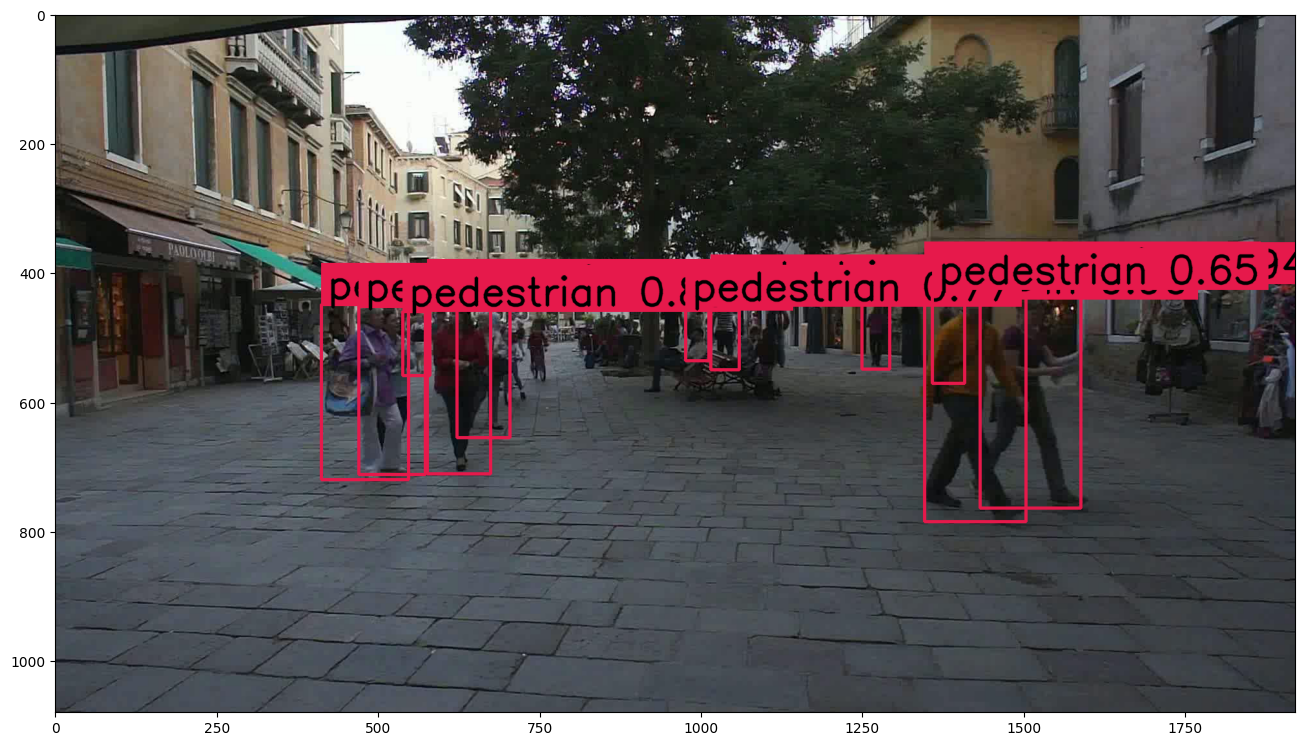

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

Matching.py qui sera appelé par byte_tracker 

Byte_tracker dont on va appeler la fonction update pour faire la mise à jour sur le tracker



In [ ]:
!pip install lap

#from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Predict and annotate whole video 

In [ ]:
folder= basic_folder+'ByteTrack/'
%cd $folder

# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = dataset_path+"Video/"+out_video_name.split("mp4")[0]+"-result.mp4" 

/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack/ByteTrack


In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)


VideoInfo(width=1920, height=1080, fps=24, total_frames=600)

In [ ]:
folder= basic_folder+"ByteTrack/yolox/tracker"
%cd $folder
import cv2
import numpy as np
import scipy
import lap
from scipy.spatial.distance import cdist

from cython_bbox import bbox_overlaps as bbox_ious
from yolox.tracker import kalman_filter
import time




def merge_matches(m1, m2, shape):
    O,P,Q = shape
    m1 = np.asarray(m1)
    m2 = np.asarray(m2)

    M1 = scipy.sparse.coo_matrix((np.ones(len(m1)), (m1[:, 0], m1[:, 1])), shape=(O, P))
    M2 = scipy.sparse.coo_matrix((np.ones(len(m2)), (m2[:, 0], m2[:, 1])), shape=(P, Q))

    mask = M1*M2
    match = mask.nonzero()
    match = list(zip(match[0], match[1]))
    unmatched_O = tuple(set(range(O)) - set([i for i, j in match]))
    unmatched_Q = tuple(set(range(Q)) - set([j for i, j in match]))

    return match, unmatched_O, unmatched_Q


def _indices_to_matches(cost_matrix, indices, thresh):
    matched_cost = cost_matrix[tuple(zip(*indices))]
    matched_mask = (matched_cost <= thresh)

    matches = indices[matched_mask]
    unmatched_a = tuple(set(range(cost_matrix.shape[0])) - set(matches[:, 0]))
    unmatched_b = tuple(set(range(cost_matrix.shape[1])) - set(matches[:, 1]))

    return matches, unmatched_a, unmatched_b


def linear_assignment(cost_matrix, thresh):
    if cost_matrix.size == 0:
        return np.empty((0, 2), dtype=int), tuple(range(cost_matrix.shape[0])), tuple(range(cost_matrix.shape[1]))
    matches, unmatched_a, unmatched_b = [], [], []
    cost, x, y = lap.lapjv(cost_matrix, extend_cost=True, cost_limit=thresh)
    for ix, mx in enumerate(x):
        if mx >= 0:
            matches.append([ix, mx])
    unmatched_a = np.where(x < 0)[0]
    unmatched_b = np.where(y < 0)[0]
    matches = np.asarray(matches)
    return matches, unmatched_a, unmatched_b


def ious(atlbrs, btlbrs):
    """
    Compute cost based on IoU
    :type atlbrs: list[tlbr] | np.ndarray
    :type atlbrs: list[tlbr] | np.ndarray

    :rtype ious np.ndarray
    """
    ious = np.zeros((len(atlbrs), len(btlbrs)), dtype=np.float)
    if ious.size == 0:
        return ious

    ious = bbox_ious(
        np.ascontiguousarray(atlbrs, dtype=np.float),
        np.ascontiguousarray(btlbrs, dtype=np.float)
    )

    return ious



def v_iou_distance(atracks, btracks):
    """
    Compute cost based on IoU
    :type atracks: list[STrack]
    :type btracks: list[STrack]

    :rtype cost_matrix np.ndarray
    """

    if (len(atracks)>0 and isinstance(atracks[0], np.ndarray)) or (len(btracks) > 0 and isinstance(btracks[0], np.ndarray)):
        atlbrs = atracks
        btlbrs = btracks
    else:
        atlbrs = [track.tlwh_to_tlbr(track.pred_bbox) for track in atracks]
        btlbrs = [track.tlwh_to_tlbr(track.pred_bbox) for track in btracks]
    _ious = ious(atlbrs, btlbrs)
    cost_matrix = 1 - _ious

    return cost_matrix

def embedding_distance(tracks, detections, metric='cosine'):
    """
    :param tracks: list[STrack]
    :param detections: list[BaseTrack]
    :param metric:
    :return: cost_matrix np.ndarray
    """

    cost_matrix = np.zeros((len(tracks), len(detections)), dtype=np.float)
    if cost_matrix.size == 0:
        return cost_matrix
    det_features = np.asarray([track.curr_feat for track in detections], dtype=np.float)
    #for i, track in enumerate(tracks):
        #cost_matrix[i, :] = np.maximum(0.0, cdist(track.smooth_feat.reshape(1,-1), det_features, metric))
    track_features = np.asarray([track.smooth_feat for track in tracks], dtype=np.float)
    cost_matrix = np.maximum(0.0, cdist(track_features, det_features, metric))  # Nomalized features
    return cost_matrix


def gate_cost_matrix(kf, cost_matrix, tracks, detections, only_position=False):
    if cost_matrix.size == 0:
        return cost_matrix
    gating_dim = 2 if only_position else 4
    gating_threshold = kalman_filter.chi2inv95[gating_dim]
    measurements = np.asarray([det.to_xyah() for det in detections])
    for row, track in enumerate(tracks):
        gating_distance = kf.gating_distance(
            track.mean, track.covariance, measurements, only_position)
        cost_matrix[row, gating_distance > gating_threshold] = np.inf
    return cost_matrix


def fuse_motion(kf, cost_matrix, tracks, detections, only_position=False, lambda_=0.98):
    if cost_matrix.size == 0:
        return cost_matrix
    gating_dim = 2 if only_position else 4
    gating_threshold = kalman_filter.chi2inv95[gating_dim]
    measurements = np.asarray([det.to_xyah() for det in detections])
    for row, track in enumerate(tracks):
        gating_distance = kf.gating_distance(
            track.mean, track.covariance, measurements, only_position, metric='maha')
        cost_matrix[row, gating_distance > gating_threshold] = np.inf
        cost_matrix[row] = lambda_ * cost_matrix[row] + (1 - lambda_) * gating_distance
    return cost_matrix


def fuse_iou(cost_matrix, tracks, detections):
    if cost_matrix.size == 0:
        return cost_matrix
    reid_sim = 1 - cost_matrix
    iou_dist = iou_distance(tracks, detections)
    iou_sim = 1 - iou_dist
    fuse_sim = reid_sim * (1 + iou_sim) / 2
    det_scores = np.array([det.score for det in detections])
    det_scores = np.expand_dims(det_scores, axis=0).repeat(cost_matrix.shape[0], axis=0)
    #fuse_sim = fuse_sim * (1 + det_scores) / 2
    fuse_cost = 1 - fuse_sim
    return fuse_cost






/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack/ByteTrack/yolox/tracker


In [ ]:
folder = basic_folder+"/ByteTrack"
%cd $folder
#!git clone https://github.com/princeton-vl/RAFT.git
%cd RAFT
sys.path.append('core')
from raft import RAFT
from utils.utils import InputPadder, forward_interpolate
model_path= "/content/drive/MyDrive/Projects/YOLO_V8_and_ByteTrack/ByteTrack/RAFT/models/raft-kitti.pth"
import torch 
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--model', help="restore checkpoint", default=model_path)
parser.add_argument('--dataset', help="dataset for evaluation", default='kitti')
parser.add_argument('--small', action='store_true', help='use small model', default=False)
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision', default=True)
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation', default=False)
#args = argparser.parse_args(["--model", model_path, "--small", False, '--dataset', 'kitti', '--mixed_precision',True, 
#                             '--alternate_corr',False, '--corr_levels',4, '--corr_radius',4, '--dropout', 0])

args = argparse.Namespace()
args.model=model_path
args.dataset = 'kitti'
args.small = False 
args.mixed_precision=True 
args.alternate_corr = False 
model_flow = torch.nn.DataParallel( RAFT(args) )


INPUT_SIZE=2
target_size=1
H=1024 # int(1242/8)
W=440#int(375/8)
C=3
  
def clean_image(folder_path, filename):
    image_path = os.path.join(folder_path, filename)
    image = Image.open(image_path)
    img_resized = image.resize((H, W))
    img_resized_normalized=np.array(img_resized).astype(np.float32)#/255.0
    return img_resized_normalized

    

/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack/ByteTrack
/content/drive/.shortcut-targets-by-id/1-0yk9GxTv936WDma10Kpm2OE1NFUwUyg/YOLO_V8_and_ByteTrack/ByteTrack/RAFT


In [ ]:
class matching:

  def __init__(self):
    print("ok")
  
  

  def iou_distance(atracks, btracks, flow):
      """
      Compute cost based on IoU
      :type atracks: list[STrack]
      :type btracks: list[STrack]
      :rtype cost_matrix np.ndarray
      """
      #supposition dim 1 c'est x et dim 2 y
      #supposition dim
      #print("**",flow.shape)
      height, width = 440, 1024 
      flow = flow.permute(1,2,0)
      flow = flow.detach()
      """def get_pixels_in_bbox(bbox):
          print('bbox',bbox)
          x_min, y_min, x_max, y_max = bbox
          x_min, y_min, x_max, y_max=int(x_min),int(y_min), int(x_max), int(y_max)
          pixel_coordinates = []
          for y in range(y_min, y_max + 1):
              for x in range(x_min, x_max + 1):
                  pixel_coordinates.append([x, y])
          return pixel_coordinates

      def get_updated_pixels(bbox, optical_flow):
          
          # Create an array with pixel positions and optical flow
          pixel_positions_with_flow = np.empty( (width,height,2), dtype=np.float32)
          for y in range(height):
              for x in range(width):
                  pixel_positions_with_flow[x,y] = [x+optical_flow[y, x,0], y+optical_flow[y, x,1]]
          pixels= get_pixels_in_bbox(bbox)
          for a in pixels:
            print("here",a, pixel_positions_with_flow.shape)
            break
          return np.array([pixel_positions_with_flow[a] for a in pixels ])"""

      def get_corner_with_applied_flow(bbox, optical_flow):
          # Create an array with pixel positions and optical flow
          #unfortunately sometimes detection are interpolated to be out of the frames, we then use the border pixel to estimate the location of the object
          H,W,_= optical_flow.shape
          x_min, y_min, x_max, y_max = bbox
          #print(x_min, y_min, x_max, y_max)
          x_min_c, y_min_c, x_max_c, y_max_c=max(min(int(x_min),0),W-1),max(min(int(y_min),0),H-1), max(min(int(x_max),0),W-1), max(min(int(y_max),0),H-1) 
         
          x_min_f, y_min_f, x_max_f, y_max_f= optical_flow[y_min_c, x_min_c,0]+x_min, optical_flow[y_min_c, x_min_c,1]+y_min, optical_flow[y_max_c, x_max_c,0]+x_max, optical_flow[y_max_c, x_max_c,1]+y_max
          return np.array([x_min_f, y_min_f, x_max_f, y_max_f])
          


      if (len(atracks)>0 and isinstance(atracks[0], np.ndarray)) or (len(btracks) > 0 and isinstance(btracks[0], np.ndarray)):
          atlbrs = atracks
          btlbrs = btracks
          """print("********************* I like pbs")
          for a in atlbrs:
                print("***",a)
                print("***",get_corner_with_applied_flow(a.tlbr))
                break"""
          #aatlbrs = [[get_pixels_in_bbox(track.tlbr)] for track in atlbrs]
      else:
          atlbrs = [track.tlbr for track in atracks]
          btlbrs = [track.tlbr for track in btracks]

          """for a in btlbrs:
                print("**$*",a)
                print("***ii",get_corner_with_applied_flow(a,flow))
                """
          #aatlbrs = [[get_pixels_in_bbox(track)] for track in atracks]
          
          bbtlbrs = [get_corner_with_applied_flow(track,flow) for track in btlbrs]
          print("****", np.array(btlbrs).shape)
          print("****2",np.array(bbtlbrs).shape)

      _ious = ious(atlbrs, bbtlbrs)
      cost_matrix = 1 - _ious

      return cost_matrix




  def linear_assignment(cost_matrix, thresh):
    if cost_matrix.size == 0:
        return np.empty((0, 2), dtype=int), tuple(range(cost_matrix.shape[0])), tuple(range(cost_matrix.shape[1]))
    matches, unmatched_a, unmatched_b = [], [], []
    cost, x, y = lap.lapjv(cost_matrix, extend_cost=True, cost_limit=thresh)
    for ix, mx in enumerate(x):
        if mx >= 0:
            matches.append([ix, mx])
    unmatched_a = np.where(x < 0)[0]
    unmatched_b = np.where(y < 0)[0]
    matches = np.asarray(matches)
    return matches, unmatched_a, unmatched_b

  def fuse_score(cost_matrix, detections):
    if cost_matrix.size == 0:
        return cost_matrix
    iou_sim = 1 - cost_matrix
    det_scores = np.array([det.score for det in detections])
    det_scores = np.expand_dims(det_scores, axis=0).repeat(cost_matrix.shape[0], axis=0)
    fuse_sim = iou_sim * det_scores
    fuse_cost = 1 - fuse_sim
    return fuse_cost

In [ ]:
#from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


from tqdm.notebook import tqdm
torch.cuda.empty_cache()


object_dict = {}

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
#########sophie mod replace video directly by  frames of kitti 
import os 
import cv2 
from PIL import Image
import torch
H=1024 # int(1242/8)
W=440#int(375/8)
video_info.width=H
video_info.height=W
video_info= VideoInfo(width=H, height= W, fps= 12, total_frames=340) 
print(video_info)
folder_path= dataset_path+"img1"


with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
  
  for idx, filename in enumerate(sorted(os.listdir(folder_path))):
    if idx>0:
      image_path = os.path.join(folder_path, filename)
      image = cv2.imread(image_path) 
      image= cv2.resize(image,(H, W), interpolation=cv2.INTER_AREA) 
      frame=image#np.array(img_resized).astype(np.float32)#/255
      #get flow
      """for file in os.listdir(flow_folder):
        if filename in file.split(" ")[1] :
          flow= torch.load(flow_folder+"/"+file)"""
    
      #print(frame.shape)
      image1= torch.tensor(np.array([clean_image(folder_path, previous)]))
      image2 =  torch.tensor(np.array([clean_image(folder_path, filename)]))
      image1, image2= image1.permute(0,3,1,2) , image2.permute(0,3,1,2)
      flow_low, flow_pr = model_flow(image1, image2, iters=24, test_mode=True)
      padder = InputPadder(image1.shape, mode='kitti')
      flow = padder.unpad(flow_pr[0]).cpu()

      results = model(frame)
      print(results[0].boxes.xyxy.cpu().numpy().shape[0])
      detections = Detections(
          xyxy=results[0].boxes.xyxy.cpu().numpy(),
          confidence=results[0].boxes.conf.cpu().numpy(),
          class_id=results[0].boxes.cls.cpu().numpy().astype(int) )
      # filtering out detections with unwanted classes
      
      mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
      detections.filter(mask=mask, inplace=True)
      #print(detections)
      # tracking detections
      tracks = byte_tracker.update(output_results=detections2boxes(detections=detections),
          img_info=frame.shape,
          img_size=frame.shape, flow=flow)###
      tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
      print("**",len(tracker_id))
      detections.tracker_id = np.array(tracker_id)
      # filtering out detections without trackers
      mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
      detections.filter(mask=mask, inplace=True)
      # format custom labels
      labels = [
          f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
          for _, confidence, class_id, tracker_id
          in detections
      ]
      # updating line counter
      line_counter.update(detections=detections)
      # annotate and display frame
      frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
      line_annotator.annotate(frame=frame, line_counter=line_counter)
      sink.write_frame(frame)
      my_ids = detections.tracker_id
      my_bounding_boxes = detections.xyxy

      for i in range(len(my_ids)):
          object_dict[(idx, my_ids[i])] = my_bounding_boxes[i]
    previous=filename 



VideoInfo(width=1024, height=440, fps=12, total_frames=340)



0: 224x512 11 pedestrians, 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
<ipython-input-295-d515fb543e18>:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._tlwh = np.asarray(tlwh, dtype=np.float)
<ipython-input-306-f52245f90f66>:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
** 11



0: 224x512 12 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
<ipython-input-306-f52245f90f66>:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.ascontiguousarray(atlbrs, dtype=np.float),
<ipython-input-306-f52245f90f66>:72: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 12



0: 224x512 11 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 10.6ms
Speed: 1.4ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.1ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 8.5ms
Speed: 1.5ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 12 pedestrians, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 12



0: 224x512 11 pedestrians, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.2ms
Speed: 1.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 10 pedestrians, 10.3ms
Speed: 1.3ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 11 pedestrians, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.5ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 10 pedestrians, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 9 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 10 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 9 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.4ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (2, 4)
****2 (2, 4)
** 11



0: 224x512 10 pedestrians, 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 10



0: 224x512 10 pedestrians, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 10



0: 224x512 10 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 10



0: 224x512 10 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 10



0: 224x512 10 pedestrians, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 10



0: 224x512 9 pedestrians, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 9



0: 224x512 9 pedestrians, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 9



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 9.9ms
Speed: 1.2ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.1ms
Speed: 1.4ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.6ms
Speed: 1.1ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 8 pedestrians, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


8
**** (8, 4)
****2 (8, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 8



0: 224x512 8 pedestrians, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


8
**** (8, 4)
****2 (8, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 8



0: 224x512 8 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


8
**** (8, 4)
****2 (8, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 8



0: 224x512 8 pedestrians, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


8
**** (8, 4)
****2 (8, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 8



0: 224x512 8 pedestrians, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


8
**** (8, 4)
****2 (8, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 8



0: 224x512 8 pedestrians, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


8
**** (8, 4)
****2 (8, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 8



0: 224x512 8 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


8
**** (8, 4)
****2 (8, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 8



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 9



0: 224x512 9 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 9 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 10 pedestrians, 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 9 pedestrians, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 9 pedestrians, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.5ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.7ms
Speed: 1.5ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 8.9ms
Speed: 1.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 9



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 9



0: 224x512 9 pedestrians, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 9



0: 224x512 9 pedestrians, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 9



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 9



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 9



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 9



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 9



0: 224x512 10 pedestrians, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 10



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 9



0: 224x512 9 pedestrians, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 10 pedestrians, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 9 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 10 pedestrians, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 9 pedestrians, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 8.8ms
Speed: 1.1ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 9 pedestrians, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


9
**** (9, 4)
****2 (9, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 9



0: 224x512 10 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 10



0: 224x512 11 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 13 pedestrians, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 12 pedestrians, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 11 pedestrians, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 11



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 11 pedestrians, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.9ms
Speed: 1.2ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 12 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 11 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 12 pedestrians, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 11 pedestrians, 7.2ms
Speed: 1.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 11 pedestrians, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 11



0: 224x512 12 pedestrians, 8.0ms
Speed: 1.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 8.7ms
Speed: 1.2ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 12 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 12



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 13



0: 224x512 13 pedestrians, 8.4ms
Speed: 1.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 13



0: 224x512 13 pedestrians, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 13



0: 224x512 12 pedestrians, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 13 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 12 pedestrians, 7.9ms
Speed: 1.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.9ms
Speed: 1.2ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 9.1ms
Speed: 1.3ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 12.6ms
Speed: 1.2ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 13 pedestrians, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 11 pedestrians, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 11



0: 224x512 11 pedestrians, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 11



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 12



0: 224x512 11 pedestrians, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 11



0: 224x512 11 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 11



0: 224x512 12 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 11 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 11 pedestrians, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 12 pedestrians, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 13 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 14 pedestrians, 8.2ms
Speed: 1.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (0,)
****2 (0,)
** 14



0: 224x512 12 pedestrians, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 11



0: 224x512 11 pedestrians, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 11



0: 224x512 11 pedestrians, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 11



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 8.5ms
Speed: 1.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 8.4ms
Speed: 1.2ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 13 pedestrians, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 12



0: 224x512 12 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 12



0: 224x512 12 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 12



0: 224x512 12 pedestrians, 9.3ms
Speed: 1.4ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 12



0: 224x512 12 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 12



0: 224x512 12 pedestrians, 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 12



0: 224x512 13 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 13



0: 224x512 13 pedestrians, 8.3ms
Speed: 1.1ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 13



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (6, 4)
****2 (6, 4)
** 12



0: 224x512 12 pedestrians, 7.7ms
Speed: 1.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (6, 4)
****2 (6, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 12



0: 224x512 13 pedestrians, 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 13



0: 224x512 13 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 12 pedestrians, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 12



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 14 pedestrians, 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 14 pedestrians, 8.3ms
Speed: 1.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 15 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 15



0: 224x512 14 pedestrians, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 14 pedestrians, 8.3ms
Speed: 1.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 12 pedestrians, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 12



0: 224x512 13 pedestrians, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.5ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 14 pedestrians, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.5ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 15 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 15 pedestrians, 7.6ms
Speed: 1.1ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 15 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 13 pedestrians, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.5ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 13 pedestrians, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.4ms
Speed: 1.1ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 12



0: 224x512 12 pedestrians, 8.6ms
Speed: 1.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 12



0: 224x512 11 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 11



0: 224x512 12 pedestrians, 8.4ms
Speed: 1.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 12



0: 224x512 13 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 13 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 13 pedestrians, 8.6ms
Speed: 1.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 13 pedestrians, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 13 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 12 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 12



0: 224x512 12 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 12



0: 224x512 12 pedestrians, 8.5ms
Speed: 1.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 12



0: 224x512 12 pedestrians, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 15 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 16 pedestrians, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
**** (2, 4)
****2 (2, 4)
** 16



0: 224x512 16 pedestrians, 8.6ms
Speed: 1.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (2, 4)
****2 (2, 4)
** 16



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 15 pedestrians, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 14 pedestrians, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 12 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 12



0: 224x512 13 pedestrians, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 14 pedestrians, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 15 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 15 pedestrians, 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 15



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 13 pedestrians, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 13 pedestrians, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 13 pedestrians, 8.6ms
Speed: 1.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.5ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 16 pedestrians, 12.4ms
Speed: 1.6ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 16



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 12



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 13 pedestrians, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (5, 4)
****2 (5, 4)
** 13



0: 224x512 13 pedestrians, 8.4ms
Speed: 1.5ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 13



0: 224x512 13 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 13



0: 224x512 13 pedestrians, 8.3ms
Speed: 1.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 13



0: 224x512 13 pedestrians, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 13 pedestrians, 8.0ms
Speed: 1.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 13 pedestrians, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 13 pedestrians, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 14 pedestrians, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 13



0: 224x512 14 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 14 pedestrians, 8.9ms
Speed: 1.3ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 14 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 14 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 15 pedestrians, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (5, 4)
****2 (5, 4)
** 15



0: 224x512 14 pedestrians, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 14 pedestrians, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (6, 4)
****2 (6, 4)
** 12



0: 224x512 13 pedestrians, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (6, 4)
****2 (6, 4)
** 13



0: 224x512 14 pedestrians, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (6, 4)
****2 (6, 4)
** 14



0: 224x512 13 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (7, 4)
****2 (7, 4)
** 13



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 14 pedestrians, 8.3ms
Speed: 1.3ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 16 pedestrians, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (4, 4)
****2 (4, 4)
** 16



0: 224x512 14 pedestrians, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 16 pedestrians, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (4, 4)
****2 (4, 4)
** 16



0: 224x512 16 pedestrians, 8.3ms
Speed: 1.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (4, 4)
****2 (4, 4)
** 16



0: 224x512 15 pedestrians, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 15 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 15 pedestrians, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 15 pedestrians, 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 15



0: 224x512 14 pedestrians, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 14 pedestrians, 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 15 pedestrians, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 14 pedestrians, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 13 pedestrians, 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 14 pedestrians, 8.4ms
Speed: 1.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 15 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 15 pedestrians, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 15 pedestrians, 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 15 pedestrians, 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 14 pedestrians, 9.0ms
Speed: 1.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.3ms
Speed: 1.1ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 14



0: 224x512 13 pedestrians, 8.9ms
Speed: 1.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 13 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
** 13



0: 224x512 15 pedestrians, 13.7ms
Speed: 1.5ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 15 pedestrians, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 14 pedestrians, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.9ms
Speed: 1.2ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 15 pedestrians, 7.9ms
Speed: 1.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 15 pedestrians, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 15 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 15



0: 224x512 16 pedestrians, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (1, 4)
****2 (1, 4)
** 16



0: 224x512 15 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 16 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (2, 4)
****2 (2, 4)
** 16



0: 224x512 15 pedestrians, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 15 pedestrians, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 15 pedestrians, 7.4ms
Speed: 1.1ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 15



0: 224x512 17 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 17



0: 224x512 18 pedestrians, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


18
**** (18, 4)
****2 (18, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (1, 4)
****2 (1, 4)
** 18



0: 224x512 17 pedestrians, 9.9ms
Speed: 1.2ms preprocess, 9.9ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 17



0: 224x512 16 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 16



0: 224x512 15 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 15



0: 224x512 17 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (2, 4)
****2 (2, 4)
** 17



0: 224x512 16 pedestrians, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 16



0: 224x512 16 pedestrians, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 16



0: 224x512 16 pedestrians, 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 16



0: 224x512 18 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


18
**** (18, 4)
****2 (18, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (3, 4)
****2 (3, 4)
** 18



0: 224x512 17 pedestrians, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 17



0: 224x512 19 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


19
**** (19, 4)
****2 (19, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (1, 4)
****2 (1, 4)
** 19



0: 224x512 19 pedestrians, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


19
**** (19, 4)
****2 (19, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (0,)
****2 (0,)
** 19



0: 224x512 16 pedestrians, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 16



0: 224x512 17 pedestrians, 7.3ms
Speed: 1.1ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 17



0: 224x512 18 pedestrians, 7.4ms
Speed: 1.5ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


18
**** (18, 4)
****2 (18, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (3, 4)
****2 (3, 4)
** 18



0: 224x512 16 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (3, 4)
****2 (3, 4)
** 16



0: 224x512 17 pedestrians, 8.7ms
Speed: 1.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 17



0: 224x512 17 pedestrians, 8.1ms
Speed: 1.2ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
**** (5, 4)
****2 (5, 4)
** 17



0: 224x512 18 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


18
**** (18, 4)
****2 (18, 4)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
**** (3, 4)
****2 (3, 4)
** 18



0: 224x512 17 pedestrians, 8.8ms
Speed: 1.3ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (3, 4)
****2 (3, 4)
** 17



0: 224x512 14 pedestrians, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 15 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 15



0: 224x512 17 pedestrians, 8.7ms
Speed: 1.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
**** (6, 4)
****2 (6, 4)
** 17



0: 224x512 15 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 15



0: 224x512 17 pedestrians, 9.0ms
Speed: 1.2ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (5, 4)
****2 (5, 4)
** 17



0: 224x512 22 pedestrians, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


22
**** (22, 4)
****2 (22, 4)
**** (0,)
****2 (0,)
**** (6, 4)
****2 (6, 4)
**** (3, 4)
****2 (3, 4)
** 22



0: 224x512 19 pedestrians, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


19
**** (19, 4)
****2 (19, 4)
**** (0,)
****2 (0,)
**** (6, 4)
****2 (6, 4)
**** (6, 4)
****2 (6, 4)
** 19



0: 224x512 20 pedestrians, 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


20
**** (20, 4)
****2 (20, 4)
**** (0,)
****2 (0,)
**** (6, 4)
****2 (6, 4)
**** (6, 4)
****2 (6, 4)
** 20



0: 224x512 21 pedestrians, 8.9ms
Speed: 1.3ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


21
**** (21, 4)
****2 (21, 4)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
**** (5, 4)
****2 (5, 4)
** 21



0: 224x512 19 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


19
**** (19, 4)
****2 (19, 4)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
**** (6, 4)
****2 (6, 4)
** 19



0: 224x512 16 pedestrians, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (7, 4)
****2 (7, 4)
** 16



0: 224x512 16 pedestrians, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (7, 4)
****2 (7, 4)
** 16



0: 224x512 15 pedestrians, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (7, 4)
****2 (7, 4)
** 15



0: 224x512 15 pedestrians, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (7, 4)
****2 (7, 4)
** 15



0: 224x512 16 pedestrians, 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (6, 4)
****2 (6, 4)
** 16



0: 224x512 18 pedestrians, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


18
**** (18, 4)
****2 (18, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (7, 4)
****2 (7, 4)
** 18



0: 224x512 15 pedestrians, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (8, 4)
****2 (8, 4)
** 15



0: 224x512 17 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (8, 4)
****2 (8, 4)
** 17



0: 224x512 15 pedestrians, 8.3ms
Speed: 1.2ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (9, 4)
****2 (9, 4)
** 15



0: 224x512 17 pedestrians, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


17
**** (17, 4)
****2 (17, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (9, 4)
****2 (9, 4)
** 17



0: 224x512 15 pedestrians, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (9, 4)
****2 (9, 4)
** 15



0: 224x512 16 pedestrians, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
**** (9, 4)
****2 (9, 4)
** 16



0: 224x512 18 pedestrians, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


18
**** (18, 4)
****2 (18, 4)
**** (0,)
****2 (0,)
**** (3, 4)
****2 (3, 4)
**** (8, 4)
****2 (8, 4)
** 18



0: 224x512 16 pedestrians, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


16
**** (16, 4)
****2 (16, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (8, 4)
****2 (8, 4)
** 16



0: 224x512 15 pedestrians, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (8, 4)
****2 (8, 4)
** 15



0: 224x512 15 pedestrians, 9.9ms
Speed: 1.5ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (8, 4)
****2 (8, 4)
** 15



0: 224x512 15 pedestrians, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (8, 4)
****2 (8, 4)
** 15



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (9, 4)
****2 (9, 4)
** 14



0: 224x512 15 pedestrians, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (9, 4)
****2 (9, 4)
** 15



0: 224x512 15 pedestrians, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (8, 4)
****2 (8, 4)
** 15



0: 224x512 15 pedestrians, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (8, 4)
****2 (8, 4)
** 15



0: 224x512 14 pedestrians, 8.3ms
Speed: 1.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (8, 4)
****2 (8, 4)
** 14



0: 224x512 14 pedestrians, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (8, 4)
****2 (8, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (7, 4)
****2 (7, 4)
** 14



0: 224x512 14 pedestrians, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (7, 4)
****2 (7, 4)
** 14



0: 224x512 14 pedestrians, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (7, 4)
****2 (7, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (7, 4)
****2 (7, 4)
** 14



0: 224x512 14 pedestrians, 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (6, 4)
****2 (6, 4)
** 14



0: 224x512 14 pedestrians, 8.9ms
Speed: 1.2ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 14 pedestrians, 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 14 pedestrians, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 14



0: 224x512 15 pedestrians, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 15



0: 224x512 15 pedestrians, 7.2ms
Speed: 1.0ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 15



0: 224x512 15 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 15



0: 224x512 15 pedestrians, 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (5, 4)
****2 (5, 4)
** 15



0: 224x512 15 pedestrians, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (5, 4)
****2 (5, 4)
** 15



0: 224x512 15 pedestrians, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


15
**** (15, 4)
****2 (15, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 15



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 14 pedestrians, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (4, 4)
****2 (4, 4)
** 14



0: 224x512 14 pedestrians, 8.5ms
Speed: 1.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 10.2ms
Speed: 1.6ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 6.9ms
Speed: 1.0ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 14



0: 224x512 14 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 13 pedestrians, 9.0ms
Speed: 1.3ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
** 14



0: 224x512 13 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 13



0: 224x512 14 pedestrians, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 8.4ms
Speed: 1.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.3ms
Speed: 1.1ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 8.2ms
Speed: 1.1ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.8ms
Speed: 1.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 14 pedestrians, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


14
**** (14, 4)
****2 (14, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 14



0: 224x512 13 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 8.2ms
Speed: 1.1ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 13 pedestrians, 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


13
**** (13, 4)
****2 (13, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 13



0: 224x512 12 pedestrians, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.8ms
Speed: 1.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 8.5ms
Speed: 1.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 12 pedestrians, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.0ms
Speed: 1.1ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 12



0: 224x512 12 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


12
**** (12, 4)
****2 (12, 4)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
**** (2, 4)
****2 (2, 4)
** 12



0: 224x512 11 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


11
**** (11, 4)
****2 (11, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (1, 4)
****2 (1, 4)
** 11



0: 224x512 10 pedestrians, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 8.6ms
Speed: 1.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 8.7ms
Speed: 1.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 10.4ms
Speed: 1.2ms preprocess, 10.4ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10



0: 224x512 10 pedestrians, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


10
**** (10, 4)
****2 (10, 4)
**** (0,)
****2 (0,)
**** (0,)
****2 (0,)
**** (2, 4)
****2 (2, 4)
** 10


Cellule d'évaluation


In [ ]:
file_gt_path = dataset_path+'gt/gt.txt'
file_pathss = dataset_path+"gt_path.txt"

frame_dict = {}

with open(file_gt_path, 'r') as file:
    for line in file:
        data = line.strip().split(',')
        frame_number = int(data[0])
        object_id = int(data[1])
        bb_left = float(data[2])
        bb_top = float(data[3])
        bb_width = float(data[4])
        bb_height = float(data[5])

        if frame_number not in frame_dict:
            frame_dict[frame_number] = []

        frame_dict[frame_number].append((object_id, bb_left, bb_top, bb_width, bb_height))

with open(file_pathss, "w") as file:
    for frame_number, objects in frame_dict.items():
        for obj in objects:
            object_id, bb_left, bb_top, bb_width, bb_height = obj
            bb_right = bb_left + bb_width
            bb_bottom = bb_top + bb_height
            #print(f"{frame_number}, {object_id}, {bb_left:.2f}, {bb_top:.2f}, {bb_right:.2f}, {bb_bottom:.2f}")
            file.write(f"{frame_number}, {object_id}, {bb_left:.2f}, {bb_top:.2f}, {bb_right:.2f}, {bb_bottom:.2f}\n")

# Read the content from the file
with open(dataset_path+'gt_path.txt', 'r') as file:
    content = file.readlines()

# Remove leading/trailing whitespaces and split each line by comma
data = [line.strip().split(',') for line in content]

# Creating the dictionary
gt_dct = {}

# Populating the dictionary
for row in data:
    frame = int(row[0].strip())
    id = int(row[1].strip())
    bbox = [float(val.strip()) for val in row[2:]]

    # Check if the frame exists in the dictionary
    if frame not in gt_dct:
        gt_dct[frame] = {}

    # Check if the ID exists in the frame
    if id not in gt_dct[frame]:
        gt_dct[frame][id] = []

    # Append the bounding box to the ID in the frame
    gt_dct[frame][id].append(bbox)

# Removing the double brackets
for frame in gt_dct:
    for id in gt_dct[frame]:
        gt_dct[frame][id] = gt_dct[frame][id][0]

# Accessing dictionary elements
# Read the content from the file
with open(dataset_path+'gt_path.txt', 'r') as file:
    content = file.readlines()

# Remove leading/trailing whitespaces and split each line by comma
data = [line.strip().split(',') for line in content]

# Creating the dictionary
gt_dct = {}

# Populating the dictionary
for row in data:
    frame = int(row[0].strip())
    id = int(row[1].strip())
    bbox = [float(val.strip()) for val in row[2:]]

    # Check if the frame exists in the dictionary
    if frame not in gt_dct:
        gt_dct[frame] = {}

    # Check if the ID exists in the frame
    if id not in gt_dct[frame]:
        gt_dct[frame][id] = []

    # Append the bounding box to the ID in the frame
    gt_dct[frame][id].append(bbox)

# Removing the double brackets
for frame in gt_dct:
    for id in gt_dct[frame]:
        gt_dct[frame][id] = gt_dct[frame][id][0]

# Accessing dictionary elements



formatted_objects = []
det_path = dataset_path+"det_path.txt"

for key, value in object_dict.items():
    frame, obj_id = key
    bbox_values = ', '.join(map(str, value))
    formatted_objects.append(f"{frame}, {obj_id}, {bbox_values}")

with open(det_path, "w") as file:
    for formatted_object in formatted_objects:
        #print(formatted_object)
        file.write(formatted_object + "\n")



# Read the content from the file
with open(dataset_path+'det_path.txt', 'r') as file:
    content = file.readlines()

# Remove leading/trailing whitespaces and split each line by comma
data = [line.strip().split(',') for line in content]

# Creating the dictionary
det_dct = {}

# Populating the dictionary
for row in data:
    frame = int(row[0].strip())
    id = int(row[1].strip())
    bbox = [float(val.strip()) for val in row[2:]]

    # Check if the frame exists in the dictionary
    if frame not in det_dct:
        det_dct[frame] = {}

    # Check if the ID exists in the frame
    if id not in det_dct[frame]:
        det_dct[frame][id] = []

    # Append the bounding box to the ID in the frame
    det_dct[frame][id].append(bbox)

# Removing the double brackets
for frame in det_dct:
    for id in det_dct[frame]:
        det_dct[frame][id] = det_dct[frame][id][0]

# Accessing dictionary elements
!pip install motmetrics





#for frame_ids in gt_dct.keys():
#gt_id = gt_dct[frame_ids].keys()
#det_id = det_dct[frame_ids].keys()
#print(gt_id) 

def iou(box1, box2):
    """
    Compute the Intersection over Union (IOU) of two bounding boxes in TLBR format.
    
    Arguments:
    box1 -- list or tuple containing the coordinates of the first box: [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    box2 -- list or tuple containing the coordinates of the second box: [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    
    Returns:
    iou -- Intersection over Union (IOU) value
    """
    
    # Extract coordinates from the bounding boxes
    top_left_x1, top_left_y1, bottom_right_x1, bottom_right_y1 = box1
    top_left_x2, top_left_y2, bottom_right_x2, bottom_right_y2 = box2
    
    # Calculate the coordinates of the intersection rectangle
    intersection_top_left_x = max(top_left_x1, top_left_x2)
    intersection_top_left_y = max(top_left_y1, top_left_y2)
    intersection_bottom_right_x = min(bottom_right_x1, bottom_right_x2)
    intersection_bottom_right_y = min(bottom_right_y1, bottom_right_y2)
    
    # Calculate the area of intersection
    intersection_width = max(0, intersection_bottom_right_x - intersection_top_left_x + 1)
    intersection_height = max(0, intersection_bottom_right_y - intersection_top_left_y + 1)
    intersection_area = intersection_width * intersection_height
    
    # Calculate the area of each bounding box
    box1_width = bottom_right_x1 - top_left_x1 + 1
    box1_height = bottom_right_y1 - top_left_y1 + 1
    box2_width = bottom_right_x2 - top_left_x2 + 1
    box2_height = bottom_right_y2 - top_left_y2 + 1
    
    box1_area = box1_width * box1_height
    box2_area = box2_width * box2_height
    
    # Calculate the Union area
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate the IOU
    iou = intersection_area / union_area
    
    return iou

import motmetrics as mm
import numpy as np

# Create an accumulator that will be updated during each frame
acc = mm.MOTAccumulator(auto_id=True)

#print(gt_dct)
#print(det_dct)
for frame_id in gt_dct.keys():
  if frame_id in det_dct.keys():
    gt_id = list(gt_dct[frame_id].keys())
    dt_id= list(det_dct[frame_id].keys())
    transition_matrix=[]

    for id in gt_id:
      transition_matrix.append([iou(gt_dct[frame_id][id], det_dct[frame_id][x]) for x in dt_id] )
    
    #print(gt_id,                     # Ground truth objects in this frame
    #   dt_id,                  # Detector hypotheses in this frame
    #    transition_matrix)
    acc.update(
        gt_id,                     # Ground truth objects in this frame
        dt_id,                  # Detector hypotheses in this frame
        transition_matrix
    )


mh = mm.metrics.create()
summary = mh.compute(acc, metrics=mm.metrics.motchallenge_metrics , name='acc')# ['num_frames', 'mota', 'motp','idf1']
print(summary)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
         idf1       idp       idr    recall  precision  num_unique_objects  \
acc  0.884827  0.880344  0.889356  0.987099   0.977096                  26   

     mostly_tracked  partially_tracked  mostly_lost  num_false_positives  \
acc              26                  0            0                  165   

     num_misses  num_switches  num_fragmentations      mota      motp  \
acc          92            72                  33  0.953863  0.000063   

     num_transfer  num_ascend  num_migrate  
acc            37          31            6  
